In [4]:
!pip install statsmodels

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('parkingLot.csv')
data['timestamp']=pd.to_datetime(data['timestamp'])
data=data.sort_values(by='timestamp')
data = data[(data['timestamp'].dt.hour >= 5) & (data['timestamp'].dt.hour < 24)]
entries = data[data['camera_id'] == 1]
exits = data[data['camera_id'] == 2]
daily_entries = entries.groupby(entries['timestamp'].dt.date).size()
daily_entries.index = pd.to_datetime(daily_entries.index) # datatime64
daily_entries.name = 'daily_entries'
matched = entries.join(exits, how='inner', lsuffix='_entry', rsuffix='_exit')
matched['time_spent'] = (matched['timestamp_exit'] - matched['timestamp_entry']).dt.total_seconds()
daily_avg_time = matched.groupby(matched['timestamp_entry'].dt.date)['time_spent'].mean()
daily_avg_time.index = pd.to_datetime(daily_avg_time.index)
daily_entries = daily_entries.asfreq('D')

In [3]:
train_entries = daily_entries[:-7]
test_entries = daily_entries[-7:]
arima_model = ARIMA(train_entries, order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(steps=7)
test_entries = test_entries.values
arima_forecast = np.array(arima_forecast)
mase_entries = mean_absolute_error(test_entries, arima_forecast) / train_entries.diff().abs().mean()
mape_entries = mean_absolute_percentage_error(test_entries, arima_forecast)
ets_model = ExponentialSmoothing(train_entries, seasonal='add', seasonal_periods=7).fit()
ets_forecast = ets_model.forecast(7)
mase_ets = mean_absolute_error(test_entries, ets_forecast) / train_entries.diff().abs().mean()
mape_ets = mean_absolute_percentage_error(test_entries, ets_forecast)
print("Results:")
print(f"ARIMA - MASE: {mase_entries:.3f}, MAPE: {mape_entries:.3f}")
print(f"ETS - MASE: {mase_ets:.3f}, MAPE: {mape_ets:.3f}")

Results:
ARIMA - MASE: 0.794, MAPE: 0.064
ETS - MASE: 0.543, MAPE: 0.044


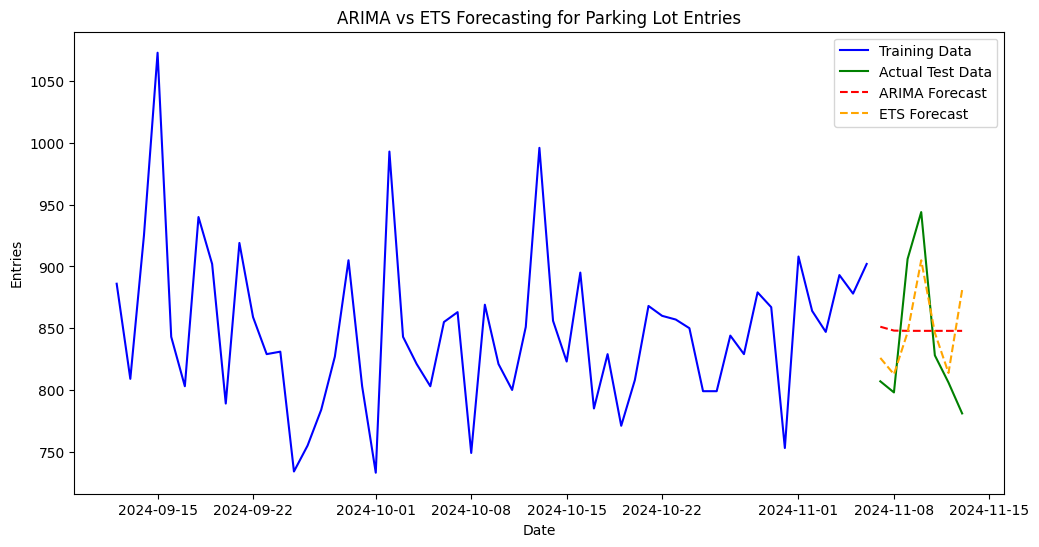

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(train_entries.index, train_entries, label='Training Data', color='blue')
plt.plot(daily_entries.index[-7:], test_entries, label='Actual Test Data', color='green')
plt.plot(daily_entries.index[-7:], arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(daily_entries.index[-7:], ets_forecast, label='ETS Forecast', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Entries')
plt.title('ARIMA vs ETS Forecasting for Parking Lot Entries')
plt.legend()
plt.show()